## ASFS Slowsled (1-min) avergae preliminary look at fluxes
Goals
- need to calculate perturbation around mean, can use metpy functions for this but may want to do this myself.
    - maybe check out how they are doing that and ask Jessica what the best way is. 
- look at w'T', w'q', w'v', w'u'
- see how they correlate with one another
- see estimate for diurnal cycle
- use 10 minute averaging time for computation of turbulence? Or 1-hour?

In [33]:
import os
import ftplib
from contextlib import closing
import urllib.request
import io

import matplotlib.pyplot as plt
import hvplot.xarray
import pandas as pd
import numpy as np
import xarray as xr

# from metpy import calc, units
# import metpy.xarray as mxarray
# import metpy.plots as metplots


In [20]:
ftp = ftplib.FTP('ftp1.esrl.noaa.gov') # Connect to NOAA's FTP
ftp.login() # Anonymous login
ftp.cwd('./Observations/Campaigns/SPLASH/asfs30/1_level_ingest')

files = ftp.nlst() # Collect files into vector
ftp.close()

turbsled_files = []
for file in files:
    if ('10min') in file and ('202112') in file:
        turbsled_files.append(file)
    


# used this as reference: https://towardsdatascience.com/an-efficient-way-to-read-data-from-the-web-directly-into-python-a526a0b4f4cb
url = 'ftp://ftp1.esrl.noaa.gov/Observations/Campaigns/SPLASH/asfs30/1_level_ingest/' + turbsled_files[0]

    req = urllib.request.Request(url)

    with urllib.request.urlopen(req) as resp:
        if i == 0:
            ds = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
        if i != 0:
            with urllib.request.urlopen(req) as resp:
                tmp = xr.open_dataset(io.BytesIO(resp.read()),engine='h5netcdf')
            ds = xr.merge([ds,tmp], compat='override')

Loading turbsled.level1.asfs30-pond.20211226.000000.10min.nc...
Loading turbsled.level1.asfs30-pond.20211227.000000.10min.nc...
Loading turbsled.level1.asfs30-pond.20211228.000000.10min.nc...


<xarray.Dataset>
Dimensions:                       (time: 1440)
Coordinates:
  * time                          (time) datetime64[ns] 2021-09-20 ... 2021-0...
Data variables: (12/98)
    base_time                     datetime64[ns] ...
    time_offset                   (time) datetime64[ns] ...
    gps_lat_deg_Avg               (time) float64 ...
    gps_lat_min_Avg               (time) float64 ...
    gps_lon_deg_Avg               (time) float64 ...
    gps_lon_min_Avg               (time) float64 ...
    ...                            ...
    ir20_lwu_fan_Avg              (time) float64 ...
    ir20_lwd_fan_Avg              (time) float64 ...
    efoy_Ubat_Avg                 (time) float64 ...
    efoy_Laus_Avg                 (time) float64 ...
    sr30_swu_tilt_Avg             (time) float64 ...
    sr30_swd_tilt_Avg             (time) float64 ...
Attributes: (12/14)
    date_created:     Thu Feb 24 17:22:06 2022
    title:            Navy buoy flux data product: 
    institution:      CIRES, University of Colorado and NOAA Physical Science...
    file_creator:     Michael R. Gallagher; Christopher J. Cox
    creator_email:    michael.r.gallagher@noaa.gov; christopher.j.cox@noaa.gov
    Funding:          What's that?
    ...               ...
    references:       
    keywords:         Polar, Arctic, Supersite, Observations, Flux, Atmospher...
    conventions:      cf convention variable naming as attribute whenever pos...
    history:          based on level 0 ingest files
    version:          0.1β\t, 1/31/2022
    quality_control:  This Level 1 product is for archival purposes and has u...

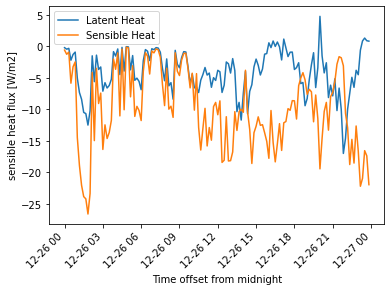

In [21]:
fig, ax = plt.subplots()
ds['bulk_Hl'].plot(x='time',ax=ax, label='Latent Heat')
ds['bulk_Hs'].plot(x='time', ax=ax, label='Sensible Heat')


# ds2.plot.scatter(x='time', y='Hl', ax=ax, label='Latent Heat')
ax.tick_params(axis='x', labelrotation=45)
ax.legend()

Figure to match Andreas 2002 to test his model of turbulent scaling. zs/z0 is related to the Reynold's roughness through:
$$ln(z_s/z_0) = b0 + b1 ln(R_*) + b2 ln(R_*)^2$$

In [62]:
ds2 = ds.assign_coords(coords={"time_local": ds.time.to_index().tz_localize(tz='US/Mountain').values})

In [43]:
ds_stable = xr.open_dataset('turbsled_10min_20220102.nc')
ds_unstable = xr.open_dataset('turbsled_10min_20211226.nc')

In [41]:
ds_stable

<xarray.Dataset>
Dimensions:        (time: 144, freq: 60)
Coordinates:
  * time           (time) datetime64[ns] 2022-01-02 ... 2022-01-02T23:50:00
Dimensions without coordinates: freq
Data variables: (12/91)
    base_time      datetime64[ns] ...
    time_offset    (time) datetime64[ns] ...
    Hs             (time) float64 ...
    Hl             (time) float64 ...
    Hl_Webb        (time) float64 ...
    CO2_flux       (time) float64 ...
    ...             ...
    bulk_Cdn_10m   (time) float64 ...
    bulk_Chn_10m   (time) float64 ...
    bulk_Cen_10m   (time) float64 ...
    bulk_Rr        (time) float64 ...
    bulk_Rt        (time) float64 ...
    bulk_Rq        (time) float64 ...
Attributes: (12/16)
    date_created:      Fri Feb  4 21:39:49 2022
    title:             Navy buoy flux data product: 
    institution:       CIRES, University of Colorado and NOAA Physical Scienc...
    file_creator:      Michael R. Gallagher; Christopher J. Cox
    creator_email:     michael.r.gallagher@noaa.gov; christopher.j.cox@noaa.gov
    Funding:           What's that?
    ...                ...
    conventions:       cf convention variable naming as attribute whenever po...
    history:           based on level 0 ingest files
    version:           0.1β\t, 1/31/2022
    quality_control:   The source data measured at 20 Hz was quality controll...
    methods:           Code developed from routines used by NOAA ETL/PSD3. Or...
    acknowledgements:  Dr. Andrey Grachev (CIRES), Dr. Chris Fairall (NOAA), ...

Text(0.5, 1.0, 'Unstable Condition')

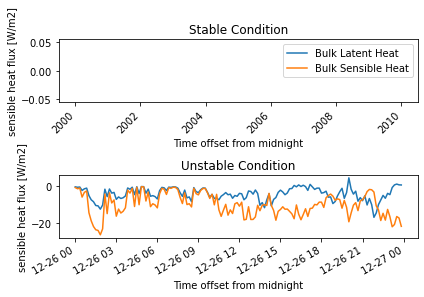

In [44]:
fig, ax = plt.subplots(2, tight_layout=True)
ds_stable['bulk_Hl'].plot(ax=ax[0], label='Bulk Latent Heat')
ds_stable['bulk_Hs'].plot(ax=ax[0], label='Bulk Sensible Heat')
ax[0].tick_params(axis='x', labelrotation=45)
ax[0].legend()
ax[0].set_title('Stable Condition')


ds_unstable['bulk_Hl'].plot(ax=ax[1], label='Bulk Latent Heat')
ds_unstable['bulk_Hs'].plot(ax=ax[1], label='Bulk Sensible Heat')
ax[1].set_title('Unstable Condition')
# ds2.plot.scatter(x='time', y='Hl', ax=ax, label='Latent Heat')


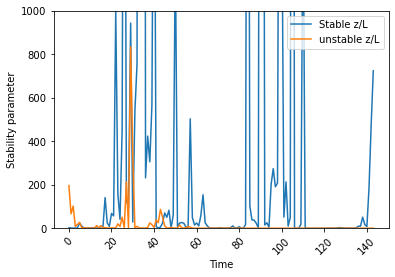

In [32]:
fig, ax = plt.subplots()
ax.plot(3.8/ds_stable['bulk_L'], label='Stable z/L')
ax.plot(3.8/ds_unstable['bulk_L'], label='unstable z/L')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlabel('Time')
ax.set_ylabel('Stability parameter')
ax.set_ylim(0,1000)
ax.legend()

In [24]:
ds_unstable

<xarray.Dataset>
Dimensions:        (time: 144, freq: 60)
Coordinates:
  * time           (time) datetime64[ns] 2021-12-26 ... 2021-12-26T23:50:00
Dimensions without coordinates: freq
Data variables: (12/91)
    base_time      datetime64[ns] ...
    time_offset    (time) datetime64[ns] ...
    Hs             (time) float64 ...
    Hl             (time) float64 ...
    Hl_Webb        (time) float64 ...
    CO2_flux       (time) float64 ...
    ...             ...
    bulk_Cdn_10m   (time) float64 ...
    bulk_Chn_10m   (time) float64 ...
    bulk_Cen_10m   (time) float64 ...
    bulk_Rr        (time) float64 ...
    bulk_Rt        (time) float64 ...
    bulk_Rq        (time) float64 ...
Attributes: (12/16)
    date_created:      Fri Feb  4 21:26:19 2022
    title:             Navy buoy flux data product: 
    institution:       CIRES, University of Colorado and NOAA Physical Scienc...
    file_creator:      Michael R. Gallagher; Christopher J. Cox
    creator_email:     michael.r.gallagher@noaa.gov; christopher.j.cox@noaa.gov
    Funding:           What's that?
    ...                ...
    conventions:       cf convention variable naming as attribute whenever po...
    history:           based on level 0 ingest files
    version:           0.1β\t, 1/31/2022
    quality_control:   The source data measured at 20 Hz was quality controll...
    methods:           Code developed from routines used by NOAA ETL/PSD3. Or...
    acknowledgements:  Dr. Andrey Grachev (CIRES), Dr. Chris Fairall (NOAA), ...

In [38]:
ds2_hourly = ds2.resample(time='H').mean()
ds2_hourly
hourly_perturbations = []
for hour in range(0,24,1):
    min_start = hour*60
    
    tmp = ds2_hourly.isel(time=hour) - ds2.isel(time=slice(min_start,min_start+60))
    tmp.drop_dims('time_local')
    hourly_perturbations.append(tmp)


In [71]:
ds2_perturbations = xr.concat(hourly_perturbations, dim='time')

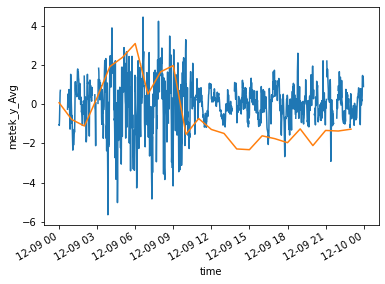

In [74]:
ds2_perturbations['metek_y_Avg'].plot()
ds2_hourly['metek_y_Avg'].plot()


In [77]:
ds2_perturbations = ds2_perturbations.drop_dims('time_local')